#Importing and installing folders

In [5]:
!pip install kneed
!pip install umap-learn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 91.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=c0c9a11d4e2d35dbf7ce6081188fdcd64e84edbe945c7c5f52c115b0b39c4a35
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [6]:
# === File & Data Management ===
import os
import pandas as pd
import numpy as np
import time

# === Data Preprocessing ===
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# === Dimensionality Reduction ===
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# === Clustering Algorithms ===
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# === Clustering Evaluation ===
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    v_measure_score,
    homogeneity_score,
    completeness_score,
    confusion_matrix,
    normalized_mutual_info_score
)
from kneed import KneeLocator
from scipy.optimize import linear_sum_assignment

# === Statistical Testing ===
from scipy.stats import shapiro, levene, kruskal, f_oneway

# === Outlier Detection ===
from sklearn.ensemble import IsolationForest

# === Feature Importance ===
from sklearn.ensemble import RandomForestClassifier

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns



#Data loading and normalization

#  IMPORTANT:
Make sure you have downloaded the dataset file from Kaggle before running this code.
Instructions on how to download and where to place the data are provided in the README file.
The code will not run correctly without the dataset!


In [8]:
# Reading the original file
file_path = 'covtype.csv' # Adjust if it's in a subfolder like 'data/covtype.csv'
df = pd.read_csv(file_path)

# Separating continuous and binary features
features = df.drop(columns=['Cover_Type'])
continuous_cols = features.columns[:10]
binary_cols = features.columns[10:]

# Normalize only continuous features
scaler = StandardScaler()
X_cont = scaler.fit_transform(features[continuous_cols])
X_bin = features[binary_cols].values

# Reunification
X_scaled = np.hstack([X_cont, X_bin])
column_names = list(continuous_cols) + list(binary_cols)



In [6]:
file_path = 'covtype.csv'
if not os.path.isfile(file_path):
    raise FileNotFoundError(f" The file '{file_path}' was not found. Please make sure it's in the project directory.")

file_path = 'covtype.csv'  # Make sure this file is in the same directory as the notebook
df = pd.read_csv(file_path)

continuous_cols = df.columns[:10]
binary_cols = df.columns[10:-1]

# Normalize the contiguous columns only ---
scaler = StandardScaler()
X_cont_scaled = scaler.fit_transform(df[continuous_cols])
X_bin = df[binary_cols].values

# Merge columns
X_scaled = np.hstack([X_cont_scaled, X_bin])
column_names = list(continuous_cols) + list(binary_cols)

# -Creating a normalized data frame
normalized_df = pd.DataFrame(X_scaled, columns=column_names)

# Add the tag column
normalized_df['Cover_Type'] = df['Cover_Type'].values

normalized_path = 'normalized_covtype_full.csv'
normalized_df.to_csv(normalized_path, index=False)
print("File saved successfully:", normalized_path)

df = pd.read_csv(normalized_path)

features = df.drop(columns=['Cover_Type'])
X_scaled = features.values

y_true = df['Cover_Type'].values


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 נשמר בהצלחה: /content/drive/MyDrive/Forest_Cover_Project_US/normalized_covtype_full.csv
✔️ נטען בהצלחה. מספר שורות: 581012


# Combinations of algorithms: clustering and dimensionality reduction

In [8]:
# Take a sample from the dataset
sampled_df = df.sample(n=10000, random_state=42)

# Define path for saving the sampled data (local)
sampled_path = 'sampled_data.csv'

# Save sampled data without the label column
sampled_df.drop(columns=['Cover_Type']).to_csv(sampled_path, index=False)


✔️ הדגימה נשמרה בהצלחה ל: /content/drive/MyDrive/Forest_Cover_Project_US/sampled_data.csv


In [3]:
# Utility function to compute and store clustering performance
def compute_and_store_score(name, X, labels, score_dict):
    """
    Calculates the Silhouette Score for a given clustering result
    and stores it in the provided dictionary.

    Parameters:
        name (str): Name/key for this clustering method.
        X (array-like): Original (non-reduced) feature data.
        labels (array-like): Cluster labels for each observation.
        score_dict (dict): Dictionary to store results.

    Notes:
        If only one cluster is found, the silhouette score is not computed.
    """
    if len(set(labels)) > 1:
        score = silhouette_score(X, labels)
        score_dict[name] = {
            'Silhouette': round(score, 3),
            'Num Clusters': len(set(labels)) - (1 if -1 in labels else 0)
        }
    else:
        score_dict[name] = {
            'Silhouette': None,
            'Num Clusters': 0
        }

# Initialize result container
scores = {}


Running various algorithms

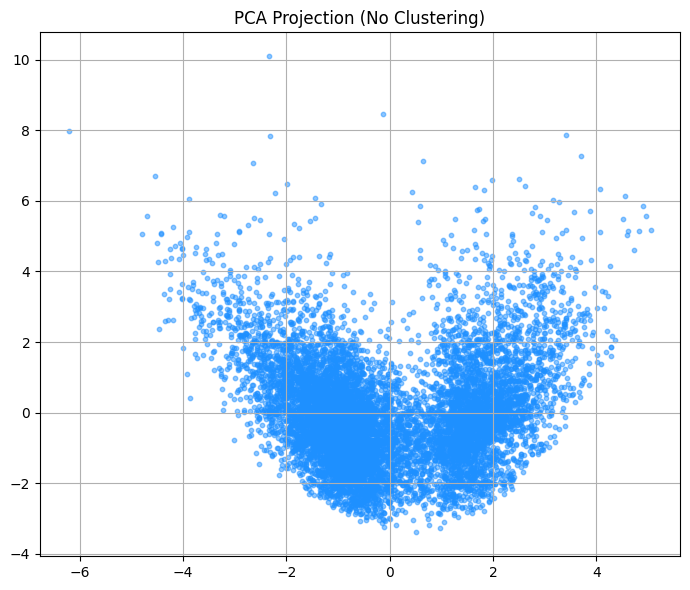

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


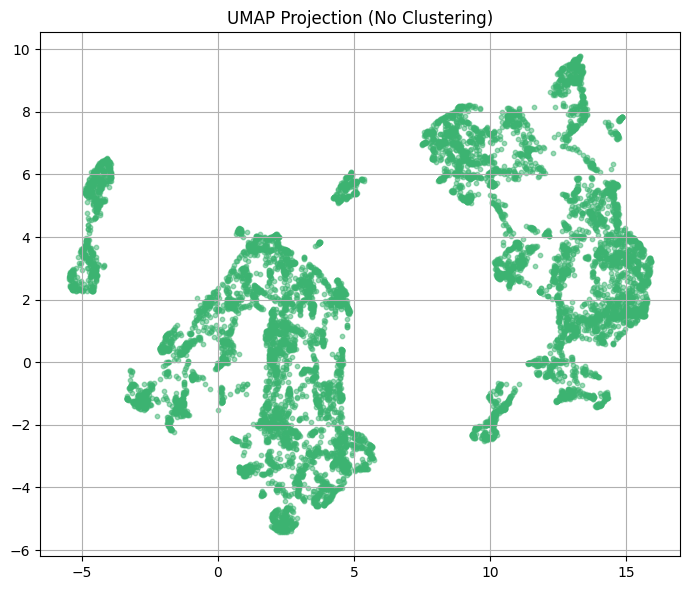

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


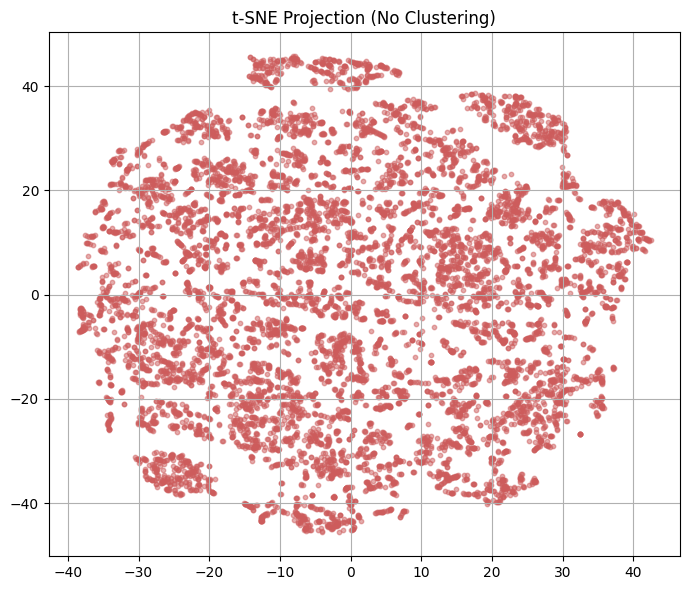

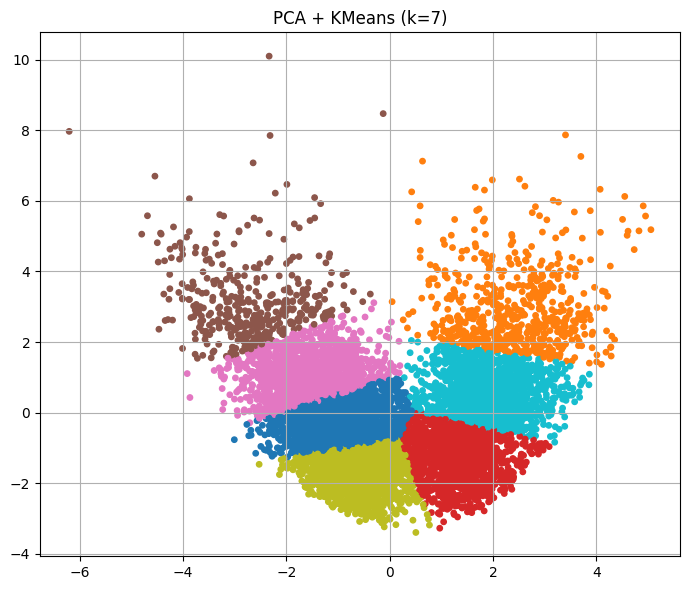

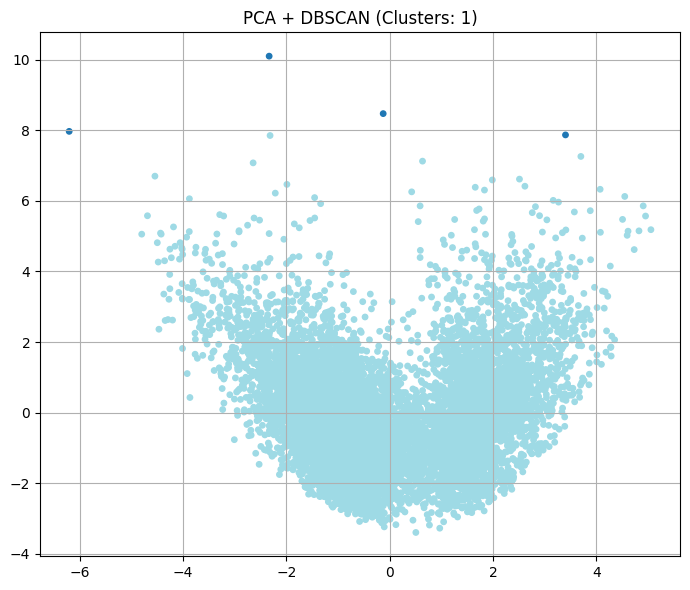

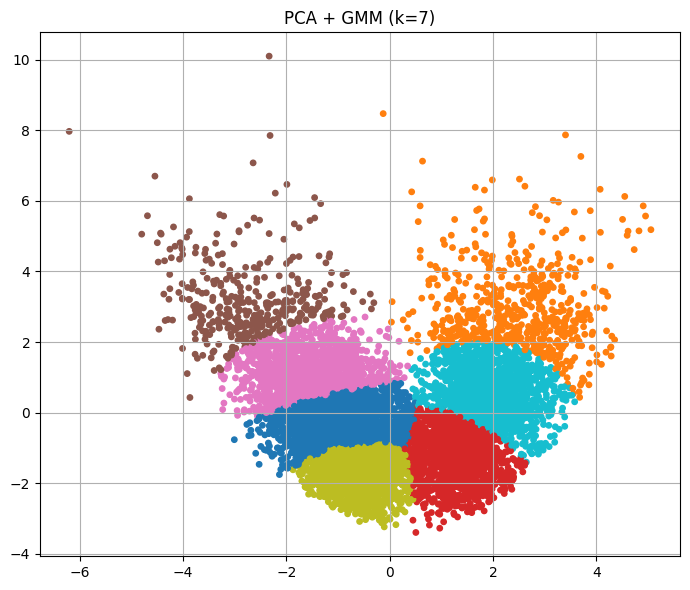

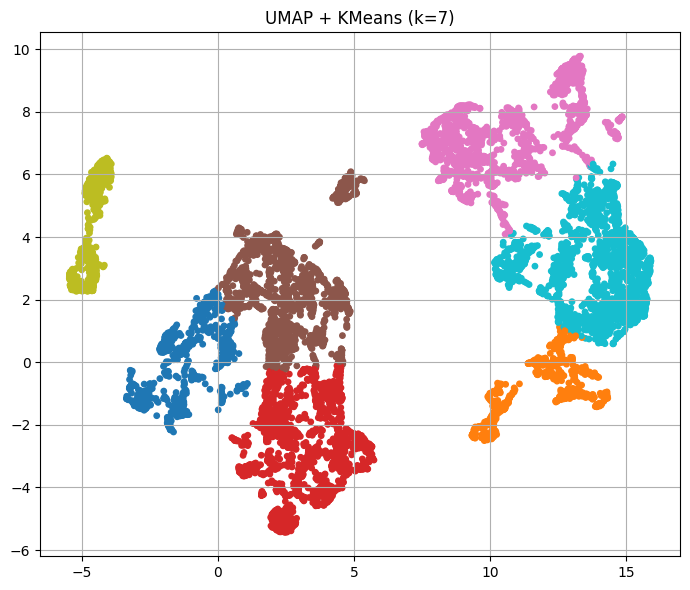

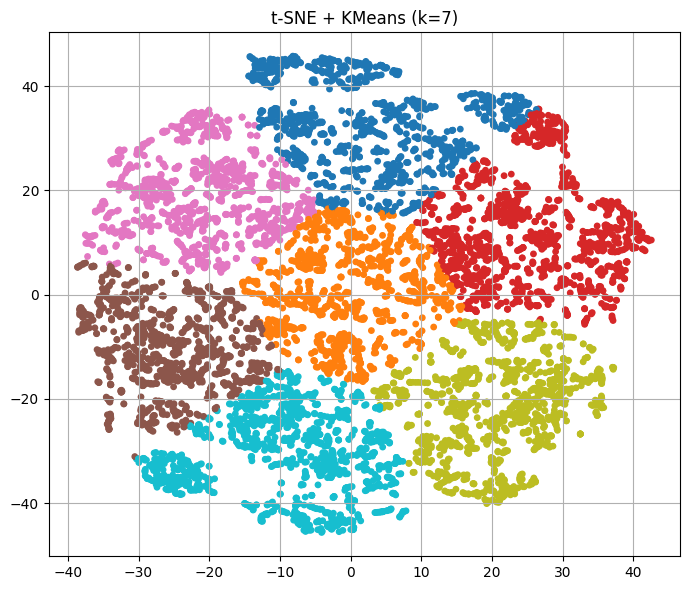

📊 Summary of Clustering Results:

        Method  Silhouette Score  Clusters
  PCA + KMeans             0.072         7
     PCA + GMM             0.071         7
 UMAP + KMeans             0.066         7
t-SNE + KMeans             0.058         7
  PCA + DBSCAN               NaN         1


In [4]:
# Load sampled data from local file
sampled_df = pd.read_csv('sampled_data.csv')
X_sampled = sampled_df.values

# Define seeds and results container
seeds = range(10)
scores = []

for seed in seeds:
    # === PCA ===
    X_pca = PCA(n_components=2, random_state=seed).fit_transform(X_sampled)

    # PCA + KMeans
    labels = KMeans(n_clusters=7, random_state=seed).fit_predict(X_pca)
    score = silhouette_score(X_sampled, labels)
    scores.append({"Method": "PCA + KMeans", "Seed": seed, "Score": score})

    # PCA + DBSCAN
    labels = DBSCAN(eps=1.5, min_samples=10).fit_predict(X_pca)
    if len(set(labels)) > 1 and -1 not in set(labels):
        score = silhouette_score(X_sampled, labels)
        scores.append({"Method": "PCA + DBSCAN", "Seed": seed, "Score": score})

    # PCA + GMM
    labels = GaussianMixture(n_components=7, random_state=seed).fit_predict(X_pca)
    score = silhouette_score(X_sampled, labels)
    scores.append({"Method": "PCA + GMM", "Seed": seed, "Score": score})

    # === UMAP ===
    X_umap = umap.UMAP(n_components=2, random_state=seed).fit_transform(X_sampled)

    # UMAP + KMeans
    labels = KMeans(n_clusters=7, random_state=seed).fit_predict(X_umap)
    score = silhouette_score(X_sampled, labels)
    scores.append({"Method": "UMAP + KMeans", "Seed": seed, "Score": score})

    # === t-SNE ===
    X_tsne = TSNE(n_components=2, random_state=seed, perplexity=30, n_iter=500, learning_rate=200).fit_transform(X_sampled)

    # t-SNE + KMeans
    labels = KMeans(n_clusters=7, random_state=seed).fit_predict(X_tsne)
    score = silhouette_score(X_sampled, labels)
    scores.append({"Method": "t-SNE + KMeans", "Seed": seed, "Score": score})

# Save results to local CSV
df_scores = pd.DataFrame(scores)
df_scores.to_csv('clustering_performance_results.csv', index=False)


Exception outliers

📊 Number of anomalies detected: 10 out of 10000 (0.10%)


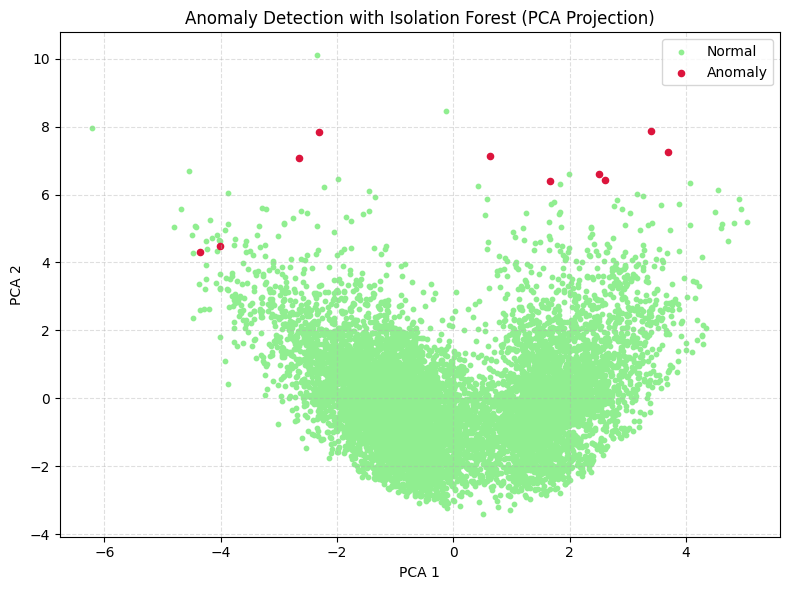

In [11]:
# --- Load the normalized data ---
df = pd.read_csv('sampled_data.csv')  # Make sure this file is in the same folder as the notebook
X = df.values  # Already normalized

# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Isolation Forest on full normalized data
iso = IsolationForest(contamination='auto', random_state=42)
anomaly_labels = iso.fit_predict(X)  # -1 for anomaly, 1 for normal

# Count and print anomaly ratio
n_total = len(anomaly_labels)
n_anomalies = np.sum(anomaly_labels == -1)
percent_anomalies = (n_anomalies / n_total) * 100

print(f"Number of anomalies detected: {n_anomalies} out of {n_total} ({percent_anomalies:.2f}%)")

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[anomaly_labels == 1, 0], X_pca[anomaly_labels == 1, 1],
            c='lightgreen', label='Normal', s=10)
plt.scatter(X_pca[anomaly_labels == -1, 0], X_pca[anomaly_labels == -1, 1],
            c='crimson', label='Anomaly', s=20)
plt.title("Anomaly Detection with Isolation Forest (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


No very severe outliers: There aren't many red dots that are really far removed from the rest of the data — meaning the outliers are "edges of the spectrum," not something very extreme. This could indicate that the data is fairly homogeneous or that the indicators of outliers are subtle.

In [34]:
# Load data from local CSV
sampled_df = pd.read_csv('sampled_data.csv')
X_sampled = sampled_df.values

# Define seeds and result container
seeds = range(7)  # Enough for quick testing and statistical comparison
scores = []

for seed in seeds:
    # === PCA ===
    X_pca = PCA(n_components=2, random_state=seed).fit_transform(X_sampled)

    # PCA + KMeans
    labels = KMeans(n_clusters=7, random_state=seed).fit_predict(X_pca)
    score = silhouette_score(X_sampled, labels)
    scores.append({"Method": "PCA + KMeans", "Seed": seed, "Score": score, "Component": "PCA", "Cluster": "KMeans"})

    # PCA + DBSCAN
    labels = DBSCAN(eps=1.5, min_samples=10).fit_predict(X_pca)
    if len(set(labels)) > 1 and -1 not in set(labels):
        score = silhouette_score(X_sampled, labels)
        scores.append({"Method": "PCA + DBSCAN", "Seed": seed, "Score": score, "Component": "PCA", "Cluster": "DBSCAN"})

    # PCA + GMM
    labels = GaussianMixture(n_components=7, random_state=seed).fit_predict(X_pca)
    score = silhouette_score(X_sampled, labels)
    scores.append({"Method": "PCA + GMM", "Seed": seed, "Score": score, "Component": "PCA", "Cluster": "GMM"})

    # === UMAP ===
    X_umap = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.5, random_state=seed).fit_transform(X_sampled)

    # UMAP + KMeans
    labels = KMeans(n_clusters=7, random_state=seed).fit_predict(X_umap)
    score = silhouette_score(X_sampled, labels)
    scores.append({"Method": "UMAP + KMeans", "Seed": seed, "Score": score, "Component": "UMAP", "Cluster": "KMeans"})

    # === t-SNE ===
    X_tsne = TSNE(n_components=2, perplexity=10, n_iter=250, learning_rate=150, random_state=seed).fit_transform(X_sampled)

    # t-SNE + KMeans
    labels = KMeans(n_clusters=7, random_state=seed).fit_predict(X_tsne)
    score = silhouette_score(X_sampled, labels)
    scores.append({"Method": "t-SNE + KMeans", "Seed": seed, "Score": score, "Component": "t-SNE", "Cluster": "KMeans"})

# Save results locally
df_scores = pd.DataFrame(scores)
df_scores.to_csv('clustering_performance_results.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter

🔍 הצצה לנתונים:
           Method  Seed     Score Component Cluster
0    PCA + KMeans     0  0.082495       PCA  KMeans
1       PCA + GMM     0  0.086310       PCA     GMM
2   UMAP + KMeans     0  0.056139      UMAP  KMeans
3  t-SNE + KMeans     0  0.064238     t-SNE  KMeans
4    PCA + KMeans     1  0.071703       PCA  KMeans


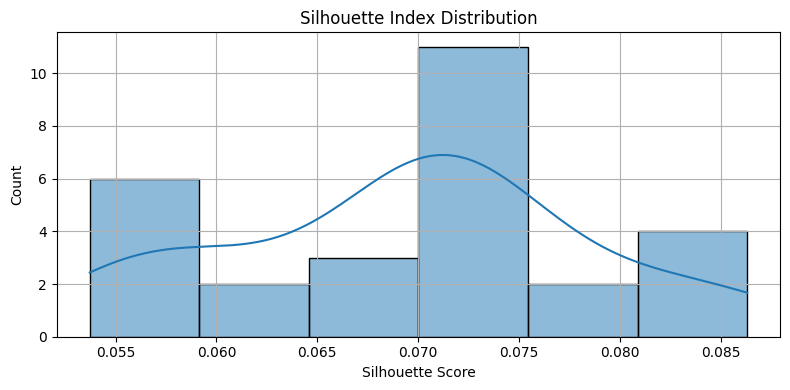


Shapiro-Wilk Test (Normality of all scores): p = 0.1267
Levene’s Test (Equality of variances): p = 0.7082
Kruskal-Wallis Test: p = 0.0008
One-way ANOVA: p = 0.0000


In [14]:
# Load results from local file
df = pd.read_csv('clustering_performance_results.csv')

# General overview
print("Preview of results:")
print(df.head())

# Graphical distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['Score'], kde=True)
plt.title("Silhouette Score Distribution")
plt.xlabel("Silhouette Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Shapiro-Wilk Test (normality) ===
shapiro_stat, shapiro_p = shapiro(df["Score"])
print(f"\nShapiro-Wilk Test (Normality): p = {shapiro_p:.4f}")

# === Levene’s Test (homogeneity of variances) ===
grouped = [group["Score"].values for _, group in df.groupby("Method")]
levene_stat, levene_p = levene(*grouped)
print(f"Levene’s Test (Equality of variances): p = {levene_p:.4f}")

# === Kruskal-Wallis Test (non-parametric) ===
kruskal_stat, kruskal_p = kruskal(*grouped)
print(f"Kruskal-Wallis Test: p = {kruskal_p:.4f}")

# === One-way ANOVA ===
anova_stat, anova_p = f_oneway(*grouped)
print(f"One-way ANOVA: p = {anova_p:.4f}")

In [16]:
df_scores = pd.read_csv('/content/drive/MyDrive/Forest_Cover_Project_US/clustering_performance_results.csv')
df_scores.groupby('Method')['Seed'].nunique()
df_scores.sort_values(by='Method').head(20)


Method  Seed     Score Component Cluster
13      PCA + GMM     3  0.085067       PCA     GMM
1       PCA + GMM     0  0.086310       PCA     GMM
25      PCA + GMM     6  0.071020       PCA     GMM
21      PCA + GMM     5  0.071266       PCA     GMM
5       PCA + GMM     1  0.071017       PCA     GMM
17      PCA + GMM     4  0.070831       PCA     GMM
9       PCA + GMM     2  0.070880       PCA     GMM
24   PCA + KMeans     6  0.071688       PCA  KMeans
20   PCA + KMeans     5  0.071960       PCA  KMeans
16   PCA + KMeans     4  0.071249       PCA  KMeans
12   PCA + KMeans     3  0.081388       PCA  KMeans
0    PCA + KMeans     0  0.082495       PCA  KMeans
8    PCA + KMeans     2  0.071532       PCA  KMeans
4    PCA + KMeans     1  0.071703       PCA  KMeans
10  UMAP + KMeans     2  0.056462      UMAP  KMeans
26  UMAP + KMeans     6  0.053722      UMAP  KMeans
14  UMAP + KMeans     3  0.062297      UMAP  KMeans
18  UMAP + KMeans     4  0.058105      UMAP  KMeans
6   UMAP + KMeans     1  0.056409      UMAP  KMeans
22  UMAP + KMeans     5  0.057935      UMAP  KMeans

In [19]:
# Extract scores for the two methods to compare
gmm_scores = df[df["Method"] == "PCA + GMM"]["Score"]
kmeans_scores = df[df["Method"] == "PCA + KMeans"]["Score"]

# T-test to compare the mean Silhouette Scores of GMM vs KMeans
t_stat, p_value = ttest_ind(gmm_scores, kmeans_scores, equal_var=False)

print("T-Test: Comparison between PCA + GMM and PCA + KMeans")
print(f"T-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")


T-statistic: 0.1885
p-value: 0.8540


# Finding the optimal number of clusters

1. Creating reduced data by PCA method
2. Elbow + silhouette method
For PCA-reduced data
3. Elbow + silhouette method
For all data
4. And comparison between the methods

In [42]:
# Load normalized data from local file
df = pd.read_csv('normalized_covtype_full.csv')  # Make sure this file is in the same folder

# Separate features and label
X = df.drop(columns=['Cover_Type']).values
y = df['Cover_Type'].values  # Optional, for evaluation

# Fit PCA and determine number of components for 95% variance
pca = PCA()
X_pca_full = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
k_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components to retain 95% variance: {k_95}")

# Transform data using selected number of components
pca = PCA(n_components=k_95)
X_pca = pca.fit_transform(X)

# Create new DataFrame with principal components
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)
df_pca['Cover_Type'] = y

# Save reduced PCA data locally
df_pca.to_csv('pca_reduced_95.csv', index=False)
print("Saved PCA-reduced dataset to: pca_reduced_95.csv")
print("Final shape:", df_pca.shape)

# Stratified 40% sampling using Cover_Type
df_pca_sampled, _, sample_indices, _ = train_test_split(
    df_pca, np.arange(len(df_pca)), test_size=0.6,
    stratify=df_pca['Cover_Type'], random_state=42
)

# Save sampled PCA data (with labels)
df_pca_sampled.to_csv('pca_reduced_95_sampled_labeled.csv', index=False)
print("Saved sampled PCA dataset with labels to: pca_reduced_95_sampled_labeled.csv")
print("Sample shape:", df_pca_sampled.shape)

# Get corresponding original rows (pre-PCA) using same indices
df_original_sampled = df.iloc[sample_indices]

# Save sampled original data (with labels)
df_original_sampled.to_csv('original_sampled_labeled.csv', index=False)
print("Saved sampled original dataset with labels to: original_sampled_labeled.csv")
print("Sample shape:", df_original_sampled.shape)

✅ Number of components to retain 95% variance: 14
📁 PCA-reduced dataset saved to:
/content/drive/MyDrive/Forest_Cover_Project_US/pca_reduced_95.csv
🧮 Final shape: (581012, 15)
📁 Sampled PCA dataset (with labels) saved to:
/content/drive/MyDrive/Forest_Cover_Project_US/pca_reduced_95_sampled_labeled.csv
🧮 Sample shape: (232404, 15)
📁 Sampled original dataset (with labels) saved to:
/content/drive/MyDrive/Forest_Cover_Project_US/original_sampled_labeled.csv
🧮 Sample shape: (232404, 55)


pca_reduced_95_sampled_labeled

🔁 Run 1/5
🔁 Run 2/5
🔁 Run 3/5
🔁 Run 4/5
🔁 Run 5/5

📍 Elbow point (PCA, 5 chunks): k = 6
📊 PCA Summary (5 chunks × 20% = 100% of sampled data):
 k  Inertia Mean  Inertia Std  Silhouette Mean  Silhouette Std
 2    415722.797     1782.891            0.196           0.002
 3    368227.389      956.068            0.155           0.003
 4    336549.605      892.327            0.163           0.002
 5    309727.354     1015.732            0.152           0.003
 6    286042.064      862.495            0.148           0.005
 7    272810.635      998.924            0.142           0.006
 8    261759.559      957.255            0.143           0.006
 9    252046.315      956.096            0.140           0.005
10    244287.944      710.708            0.135           0.010
11    236832.932      637.538            0.128           0.009
12    229839.867      837.302            0.128           0.007


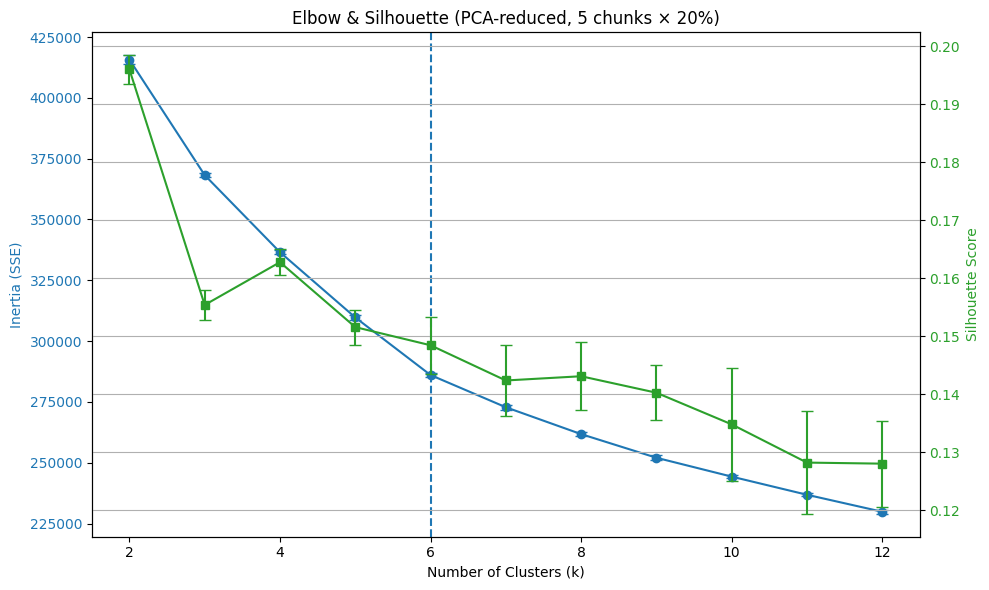


⏱️ Total runtime: 64.74 seconds


In [44]:
# Load sampled PCA-reduced dataset
df = pd.read_csv('pca_reduced_95_sampled_labeled.csv')
X_pca = df.drop(columns=['Cover_Type']).values

# Parameters
k_values = list(range(2, 13))
n_chunks = 5
all_results = []

# Split data into 5 non-overlapping chunks
chunks = np.array_split(X_pca, n_chunks)

start_time = time.time()

# Run clustering on each chunk
for run, chunk in enumerate(chunks, start=1):
    print(f"Run {run}/{n_chunks}")
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
        labels = kmeans.fit_predict(chunk)
        sil = silhouette_score(chunk, labels, sample_size=1000, random_state=42)
        inertia = kmeans.inertia_
        all_results.append({
            'Run': run,
            'k': k,
            'Inertia': inertia,
            'Silhouette': sil
        })

# Combine and summarize results
results_df = pd.DataFrame(all_results)

summary_df = results_df.groupby('k').agg({
    'Inertia': ['mean', 'std'],
    'Silhouette': ['mean', 'std']
}).reset_index()

summary_df.columns = ['k', 'Inertia Mean', 'Inertia Std', 'Silhouette Mean', 'Silhouette Std']

# Find Elbow point
knee = KneeLocator(summary_df['k'], summary_df['Inertia Mean'], curve='convex', direction='decreasing')

print(f"\nElbow point (based on Inertia): k = {knee.knee}")
print("Summary of clustering performance across 5 chunks:")
print(summary_df.to_string(index=False, float_format="{:.3f}".format))

# Plot Elbow and Silhouette metrics
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia (SSE)", color='tab:blue')
ax1.errorbar(summary_df['k'], summary_df['Inertia Mean'], yerr=summary_df['Inertia Std'],
             fmt='-o', color='tab:blue', capsize=4)
ax1.axvline(x=knee.knee, linestyle='--', color='tab:blue', label=f'Elbow at k={knee.knee}')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel("Silhouette Score", color='tab:green')
ax2.errorbar(summary_df['k'], summary_df['Silhouette Mean'], yerr=summary_df['Silhouette Std'],
             fmt='-s', color='tab:green', capsize=4)
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title("Elbow and Silhouette Scores across k values (5 data chunks)")
plt.grid(True)
plt.tight_layout()
plt.show()

end_time = time.time()
print(f"\nTotal runtime: {end_time - start_time:.2f} seconds")

original_sampled_labeled

🔁 Run 1/5
🔁 Run 2/5
🔁 Run 3/5
🔁 Run 4/5
🔁 Run 5/5

📍 Elbow point (PCA, 5 chunks): k = 6
📊 PCA Summary (5 chunks × 20% = 100% of sampled data):
 k  Inertia Mean  Inertia Std  Silhouette Mean  Silhouette Std
 2    439774.401     1775.149            0.186           0.003
 3    392262.660      960.892            0.147           0.002
 4    360579.753      906.569            0.153           0.002
 5    333753.589     1041.457            0.142           0.003
 6    310052.707      891.115            0.138           0.005
 7    296917.284     1114.050            0.129           0.005
 8    285838.207      959.897            0.131           0.006
 9    276004.506      983.150            0.128           0.005
10    268005.075     1053.380            0.120           0.003
11    260615.245     1038.403            0.118           0.007
12    253538.553      864.564            0.117           0.007


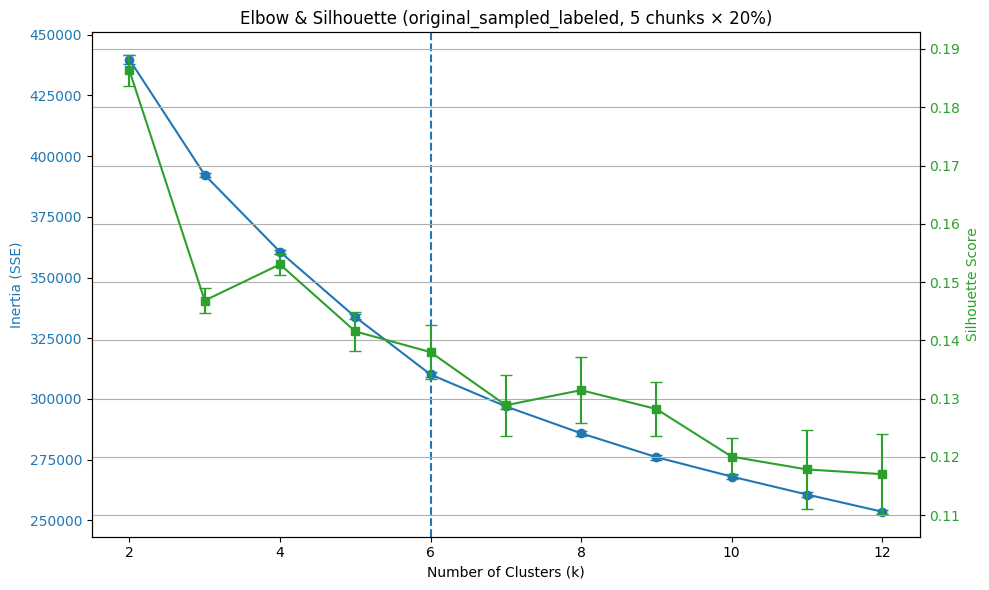


⏱️ Total runtime: 162.12 seconds


In [15]:
# Load sampled original data with labels
df = pd.read_csv('original_sampled_labeled.csv')
X = df.drop(columns=['Cover_Type']).values

# Parameters
k_values = list(range(2, 13))
n_chunks = 5
all_results = []

# Split sampled data into 5 chunks (each ~20%)
chunks = np.array_split(X, n_chunks)

start_time = time.time()

# Run KMeans clustering on each chunk
for run, chunk in enumerate(chunks, start=1):
    print(f"Run {run}/{n_chunks}")
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
        labels = kmeans.fit_predict(chunk)
        sil = silhouette_score(chunk, labels, sample_size=1000, random_state=42)
        inertia = kmeans.inertia_
        all_results.append({
            'Run': run,
            'k': k,
            'Inertia': inertia,
            'Silhouette': sil
        })

# Combine results
results_df = pd.DataFrame(all_results)

# Aggregate metrics across chunks
summary_df = results_df.groupby('k').agg({
    'Inertia': ['mean', 'std'],
    'Silhouette': ['mean', 'std']
}).reset_index()

summary_df.columns = ['k', 'Inertia Mean', 'Inertia Std', 'Silhouette Mean', 'Silhouette Std']

# Determine Elbow point using Inertia
knee = KneeLocator(summary_df['k'], summary_df['Inertia Mean'], curve='convex', direction='decreasing')

# Print summary
print(f"\nElbow point (original data, 5 chunks): k = {knee.knee}")
print("Summary of clustering performance across 5 chunks (original data):")
print(summary_df.to_string(index=False, float_format="{:.3f}".format))

# Plot Elbow and Silhouette metrics
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia (SSE)", color='tab:blue')
ax1.errorbar(summary_df['k'], summary_df['Inertia Mean'], yerr=summary_df['Inertia Std'],
             fmt='-o', color='tab:blue', capsize=4)
ax1.axvline(x=knee.knee, linestyle='--', color='tab:blue', label=f'Elbow at k={knee.knee}')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel("Silhouette Score", color='tab:green')
ax2.errorbar(summary_df['k'], summary_df['Silhouette Mean'], yerr=summary_df['Silhouette Std'],
             fmt='-s', color='tab:green', capsize=4)
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title("Elbow and Silhouette (original_sampled_labeled, 5 chunks)")
plt.grid(True)
plt.tight_layout()
plt.show()

end_time = time.time()
print(f"\nTotal runtime: {end_time - start_time:.2f} seconds")

# Comparison between the labels for the data that underwent PCA and the data that did not undergo PCA

📊 Clustering Summary (k=6):
🔹 Normalized  →  Silhouette: 0.1441  | Time: 3.43 sec
🔸 PCA-Reduced →  Silhouette: 0.1546  | Time: 2.21 sec

📋 Summary Table:

     Method  Silhouette Score  Runtime (sec)
 Normalized          0.144068           3.43
PCA-Reduced          0.154644           2.21


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


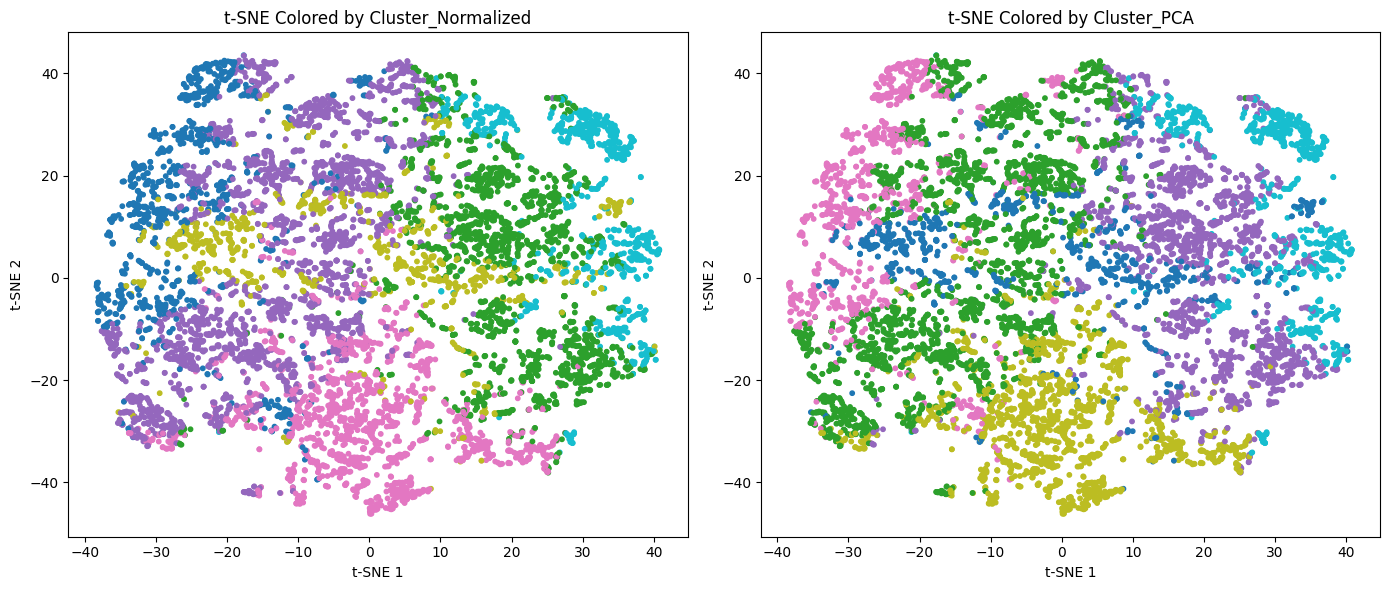

In [2]:
# Load both datasets from local files
df_norm = pd.read_csv('original_sampled_labeled.csv')
df_pca = pd.read_csv('pca_reduced_95_sampled_labeled.csv')

# Select same 10,000 random rows
np.random.seed(42)
idx = np.random.choice(df_norm.shape[0], size=10000, replace=False)

X_norm = df_norm.drop(columns=['Cover_Type']).iloc[idx].values
X_pca = df_pca.drop(columns=['Cover_Type']).iloc[idx].values
cover = df_norm['Cover_Type'].iloc[idx].values  # Label

# Run KMeans on normalized data
start_norm = time.time()
kmeans_norm = KMeans(n_clusters=6, random_state=42, n_init=10)
cluster_norm = kmeans_norm.fit_predict(X_norm)
sil_norm = silhouette_score(X_norm, cluster_norm)
time_norm = time.time() - start_norm

# Run KMeans on PCA-reduced data
start_pca = time.time()
kmeans_pca = KMeans(n_clusters=6, random_state=42, n_init=10)
cluster_pca = kmeans_pca.fit_predict(X_pca)
sil_pca = silhouette_score(X_pca, cluster_pca)
time_pca = time.time() - start_pca

# Combine into one DataFrame
df_combined = pd.DataFrame(X_norm, columns=df_norm.drop(columns=['Cover_Type']).columns)
df_combined['Cluster_Normalized'] = cluster_norm
df_combined['Cluster_PCA'] = cluster_pca
df_combined['Cover_Type'] = cover

# Save comparison data locally
df_combined.to_csv('comparison_clusters_pca_vs_normalized.csv', index=False)

# Print results
print("Clustering Summary (k=6):")
print(f"Normalized  →  Silhouette: {sil_norm:.4f}  | Time: {time_norm:.2f} sec")
print(f"PCA-Reduced →  Silhouette: {sil_pca:.4f}  | Time: {time_pca:.2f} sec")

# Create and display comparison table
comparison_df = pd.DataFrame({
    "Method": ["Normalized", "PCA-Reduced"],
    "Silhouette Score": [sil_norm, sil_pca],
    "Runtime (sec)": [round(time_norm, 2), round(time_pca, 2)]
})
print("\nSummary Table:\n")
print(comparison_df.to_string(index=False))

# Run t-SNE on original normalized features
tsne = TSNE(n_components=2, perplexity=30, n_iter=500, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_norm)

# Plot t-SNE projections colored by clusters
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_norm, cmap='tab10', s=10)
axs[0].set_title("t-SNE Colored by Cluster (Normalized)")
axs[0].set_xlabel("t-SNE 1")
axs[0].set_ylabel("t-SNE 2")

axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_pca, cmap='tab10', s=10)
axs[1].set_title("t-SNE Colored by Cluster (PCA-Reduced)")
axs[1].set_xlabel("t-SNE 1")
axs[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

Although PCA reduces dimensionality, it manages to preserve the structure of the data and even sharpens the separation between the clusters.
This is reflected both in the Silhouette index, and also visually clear in the t-SNE plot.


📊 Adjusted Rand Index (ARI): 0.9896
📊 V-Measure: 0.9841
🔹 Homogeneity: 0.9837
🔹 Completeness: 0.9846

✅ Matching Accuracy between Clustering Methods: 0.9958


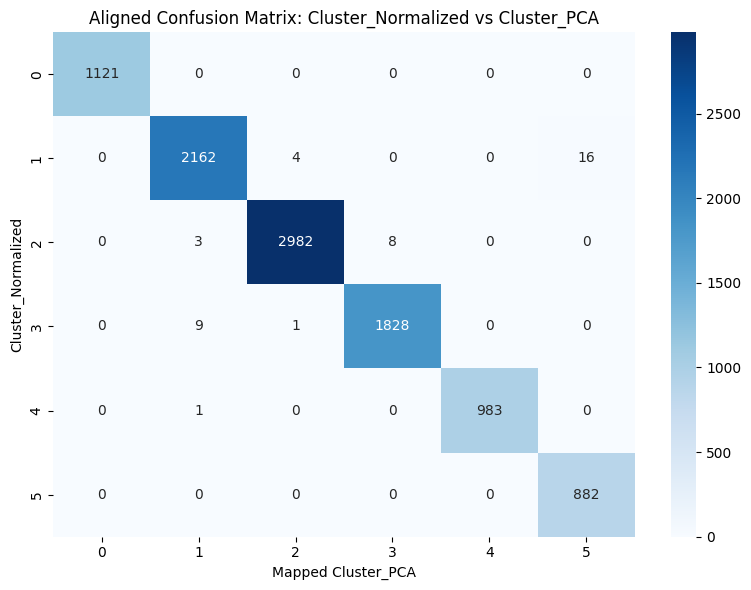

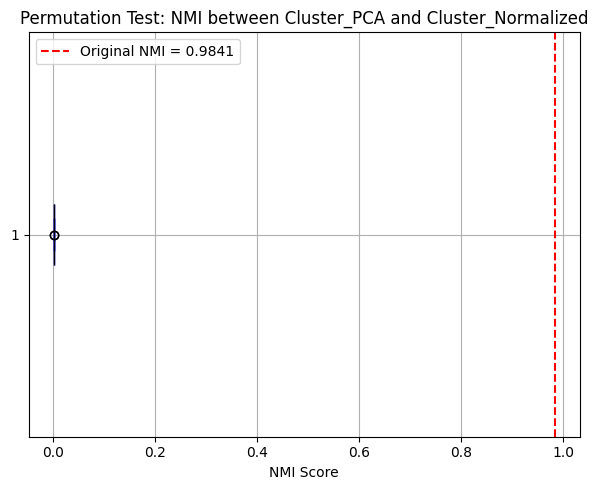


📊 Original NMI: 0.9841
📉 Permutation-based p-value: 0.0000


In [11]:
# Load dataset
df = pd.read_csv('comparison_clusters_pca_vs_normalized.csv')

# Extract clustering labels (ignore true labels)
labels_pca = df['Cluster_PCA']
labels_norm = df['Cluster_Normalized']

# Similarity metrics
ari = adjusted_rand_score(labels_pca, labels_norm)
v_measure = v_measure_score(labels_pca, labels_norm)
homogeneity = homogeneity_score(labels_pca, labels_norm)
completeness = completeness_score(labels_pca, labels_norm)

print(f"\nAdjusted Rand Index (ARI): {ari:.4f}")
print(f"V-Measure: {v_measure:.4f}")
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")

# Hungarian algorithm (confusion matrix alignment)
conf_mat = confusion_matrix(labels_norm, labels_pca)
row_ind, col_ind = linear_sum_assignment(-conf_mat)
mapping_dict = {col: row for row, col in zip(row_ind, col_ind)}
mapped_preds = labels_pca.map(mapping_dict)
accuracy = np.mean(mapped_preds == labels_norm)

print(f"\nMatching Accuracy between Clustering Methods: {accuracy:.4f}")

# Visualize aligned confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(labels_norm, mapped_preds), annot=True, fmt='d', cmap='Blues')
plt.title('Aligned Confusion Matrix: Cluster_Normalized vs Cluster_PCA')
plt.xlabel('Mapped Cluster_PCA')
plt.ylabel('Cluster_Normalized')
plt.tight_layout()
plt.show()

# Permutation test on NMI
nmi_original = normalized_mutual_info_score(labels_pca, labels_norm)
n_permutations = 100
permuted_nmis = []

for _ in range(n_permutations):
    shuffled = np.random.permutation(labels_norm)
    permuted_nmis.append(normalized_mutual_info_score(labels_pca, shuffled))

# Boxplot of permutation results
plt.figure(figsize=(6, 5))
plt.boxplot(permuted_nmis, vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'))
plt.axvline(nmi_original, color='red', linestyle='--', label=f'Original NMI = {nmi_original:.4f}')
plt.title('Permutation Test: NMI between Cluster_PCA and Cluster_Normalized')
plt.xlabel('NMI Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate p-value
p_value = np.mean([score >= nmi_original for score in permuted_nmis])
print(f"\nOriginal NMI: {nmi_original:.4f}")
print(f"Permutation-based p-value: {p_value:.4f}")

📊 Cluster Distribution Comparison (% of samples):
   PCA Cluster %  Normalized Cluster %
0           9.83                 11.21
1          29.87                 21.82
2          21.75                 29.93
3          11.21                 18.38
4          18.36                  9.84
5           8.98                  8.82


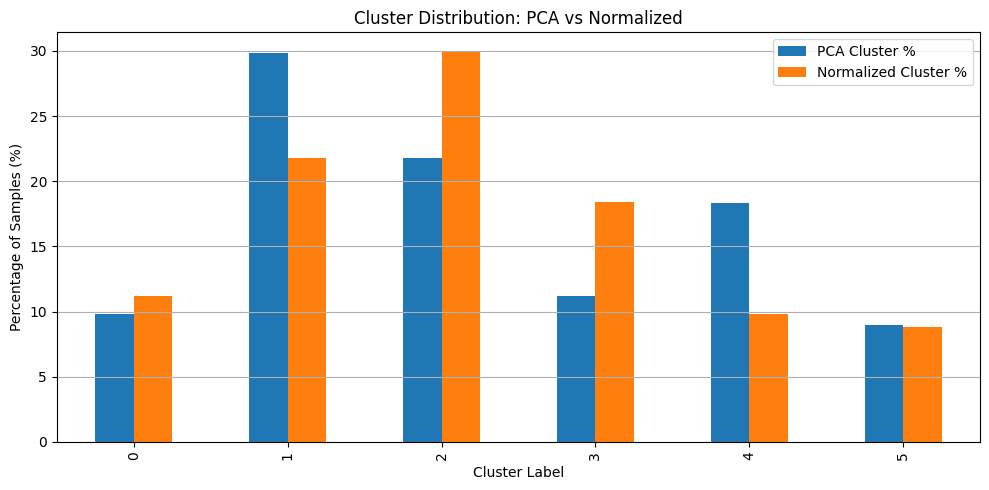

In [16]:
# Load dataset
df = pd.read_csv('comparison_clusters_pca_vs_normalized.csv')

# Compute cluster distributions (as percentages)
pca_counts = df['Cluster_PCA'].value_counts(normalize=True).sort_index() * 100
norm_counts = df['Cluster_Normalized'].value_counts(normalize=True).sort_index() * 100

# Create comparison table
comparison_df = pd.DataFrame({
    'PCA Cluster %': pca_counts,
    'Normalized Cluster %': norm_counts
}).round(2)

print("Cluster Distribution Comparison (% of samples):")
print(comparison_df)

# Plot comparison
comparison_df.plot(kind='bar', figsize=(10, 5))
plt.title("Cluster Distribution: PCA vs Normalized")
plt.xlabel("Cluster Label")
plt.ylabel("Percentage of Samples (%)")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The code Comparison without matching
python
Copy code
df['Cluster_PCA'].value_counts()
It only checks the size of the groups as they appeared – that is, how many samples were assigned to cluster 0, 1, 2... in both methods.

But there is no attempt to match the numbers (for example: does Cluster 1 of PCA really describe the same cluster as Cluster 1 of Normalized).

The result is: you cannot directly compare the columns, because Cluster 2 in one method may actually be Cluster 5 in the other method.

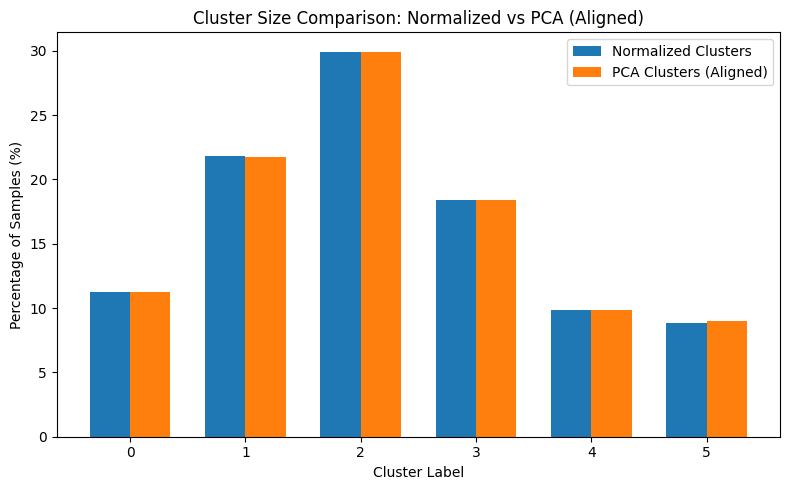

In [17]:
# Load dataset
df = pd.read_csv('comparison_clusters_pca_vs_normalized.csv')

# Extract labels
labels_norm = df['Cluster_Normalized']
labels_pca = df['Cluster_PCA']

# Align PCA clusters to normalized clusters using confusion matrix + Hungarian algorithm
conf_mat = confusion_matrix(labels_norm, labels_pca)
row_ind, col_ind = linear_sum_assignment(-conf_mat)  # maximize matches
mapping_dict = {col: row for row, col in zip(row_ind, col_ind)}
df['Mapped_Cluster_PCA'] = df['Cluster_PCA'].map(mapping_dict)

# Count group sizes (as percentages)
norm_counts = df['Cluster_Normalized'].value_counts(normalize=True).sort_index() * 100
pca_mapped_counts = df['Mapped_Cluster_PCA'].value_counts(normalize=True).sort_index() * 100

# Bar plot comparison
bar_width = 0.35
x = np.arange(len(norm_counts))

plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, norm_counts, width=bar_width, label='Normalized Clusters')
plt.bar(x + bar_width/2, pca_mapped_counts, width=bar_width, label='PCA Clusters (Aligned)')

plt.xlabel('Cluster Label')
plt.ylabel('Percentage of Samples (%)')
plt.title('Cluster Size Comparison: Normalized vs PCA (Aligned)')
plt.xticks(x)
plt.legend()
plt.tight_layout()
plt.show()


Comparison after matching (Hungarian Algorithm)



#Comparison of everything


🔍 Results for Cluster_PCA vs Cover_Type:
📊 Adjusted Rand Index (ARI): 0.0240
📊 V-Measure: 0.0535
🔹 Homogeneity: 0.0643
🔹 Completeness: 0.0457
🧠 Normalized Mutual Info (NMI): 0.0535
✅ Matching Accuracy after alignment: 0.2947


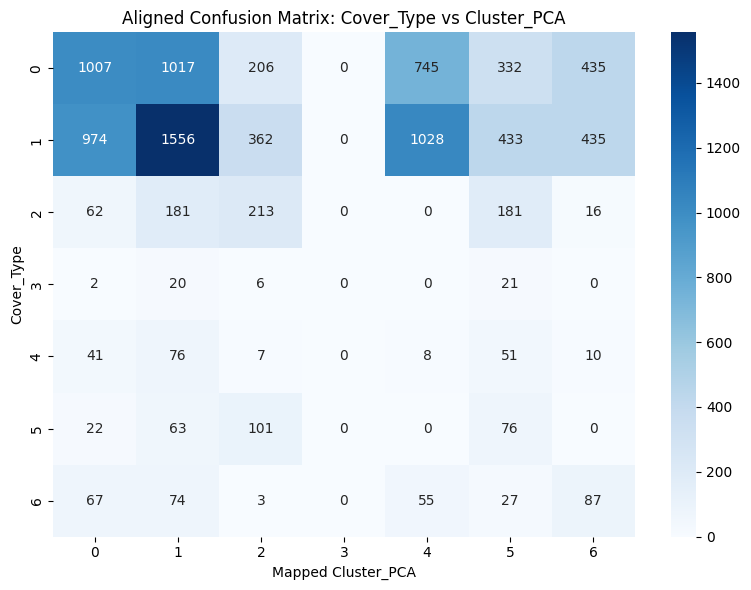


🔍 Results for Cluster_Normalized vs Cover_Type:
📊 Adjusted Rand Index (ARI): 0.0235
📊 V-Measure: 0.0527
🔹 Homogeneity: 0.0633
🔹 Completeness: 0.0451
🧠 Normalized Mutual Info (NMI): 0.0527
✅ Matching Accuracy after alignment: 0.2935


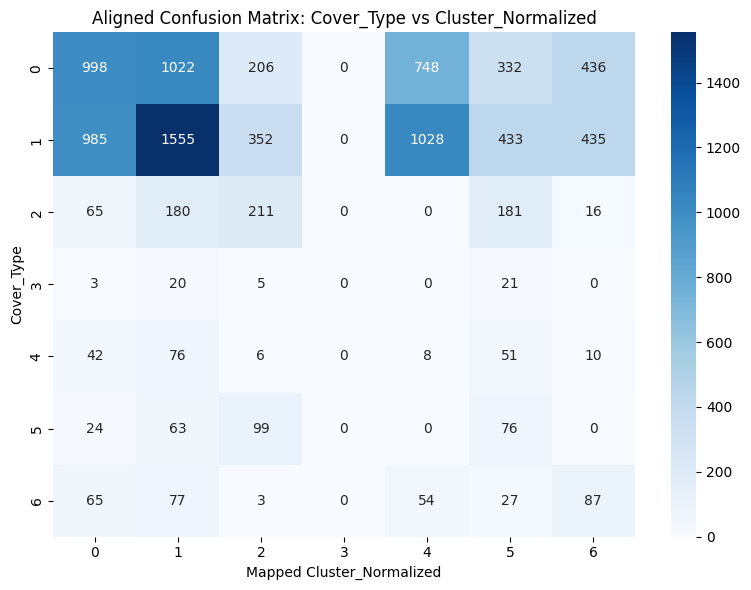

In [7]:
# Load dataset from local file
df = pd.read_csv('comparison_clusters_pca_vs_normalized.csv')

# Extract true labels and clustering results
true_labels = df['Cover_Type']
cluster_pca = df['Cluster_PCA']
cluster_norm = df['Cluster_Normalized']

# Evaluation function comparing clustering vs true labels
def evaluate_clustering(pred_labels, true_labels, method_name):
    print(f"\nEvaluation: {method_name} vs Cover_Type")

    # Metrics
    ari = adjusted_rand_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)

    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"V-Measure: {v_measure:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"Normalized Mutual Info (NMI): {nmi:.4f}")

    # Hungarian alignment to improve matching
    conf_mat = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-conf_mat)
    mapping_dict = {col: row for row, col in zip(row_ind, col_ind)}
    mapped_preds = pd.Series(pred_labels).map(mapping_dict)

    # Accuracy after alignment
    accuracy = np.mean(mapped_preds == true_labels)
    print(f"Matching Accuracy after alignment: {accuracy:.4f}")

    # Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(true_labels, mapped_preds), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Aligned Confusion Matrix: Cover_Type vs {method_name}')
    plt.xlabel(f'Mapped {method_name}')
    plt.ylabel('Cover_Type')
    plt.tight_layout()
    plt.show()

# Run evaluation on both clustering methods
evaluate_clustering(cluster_pca, true_labels, method_name="Cluster_PCA")
evaluate_clustering(cluster_norm, true_labels, method_name="Cluster_Normalized")


In [7]:
# Identify feature columns (excluding label and clusters)
feature_cols = df.drop(columns=['Cover_Type', 'Cluster_Normalized', 'Cluster_PCA']).columns
kruskal_results = []

# Run Kruskal-Wallis test per feature across clusters
for col in feature_cols:
    groups = [df[df['Cluster_Normalized'] == k][col] for k in sorted(df['Cluster_Normalized'].unique())]
    try:
        stat, pval = kruskal(*groups)
        kruskal_results.append((col, pval))
    except ValueError:
        continue  # Skip features with insufficient variation

# Create DataFrame of results
kruskal_df = pd.DataFrame(kruskal_results, columns=['Feature', 'p-value']).sort_values(by='p-value')

# Show full results
print("Kruskal-Wallis Test Results (sorted by p-value):")
print(kruskal_df.to_string(index=False))

# Show statistically significant features
significant_features = kruskal_df[kruskal_df['p-value'] < 0.05]
print(f"\nNumber of statistically significant features (p < 0.05): {len(significant_features)}")
print(significant_features.to_string(index=False))


Kruskal-Wallis Test Results (sorted by p-value):
                           Feature       p-value
                         Elevation  0.000000e+00
                            Aspect  0.000000e+00
                             Slope  0.000000e+00
  Horizontal_Distance_To_Hydrology  0.000000e+00
    Vertical_Distance_To_Hydrology  0.000000e+00
   Horizontal_Distance_To_Roadways  0.000000e+00
                     Hillshade_9am  0.000000e+00
                    Hillshade_Noon  0.000000e+00
                     Hillshade_3pm  0.000000e+00
Horizontal_Distance_To_Fire_Points  0.000000e+00
                  Wilderness_Area1  0.000000e+00
                  Wilderness_Area3  0.000000e+00
                  Wilderness_Area4  0.000000e+00
                       Soil_Type10 5.027184e-270
                       Soil_Type29 2.758588e-199
                       Soil_Type32 1.999806e-131
                       Soil_Type12 7.568749e-106
                       Soil_Type33 6.120004e-101
                    

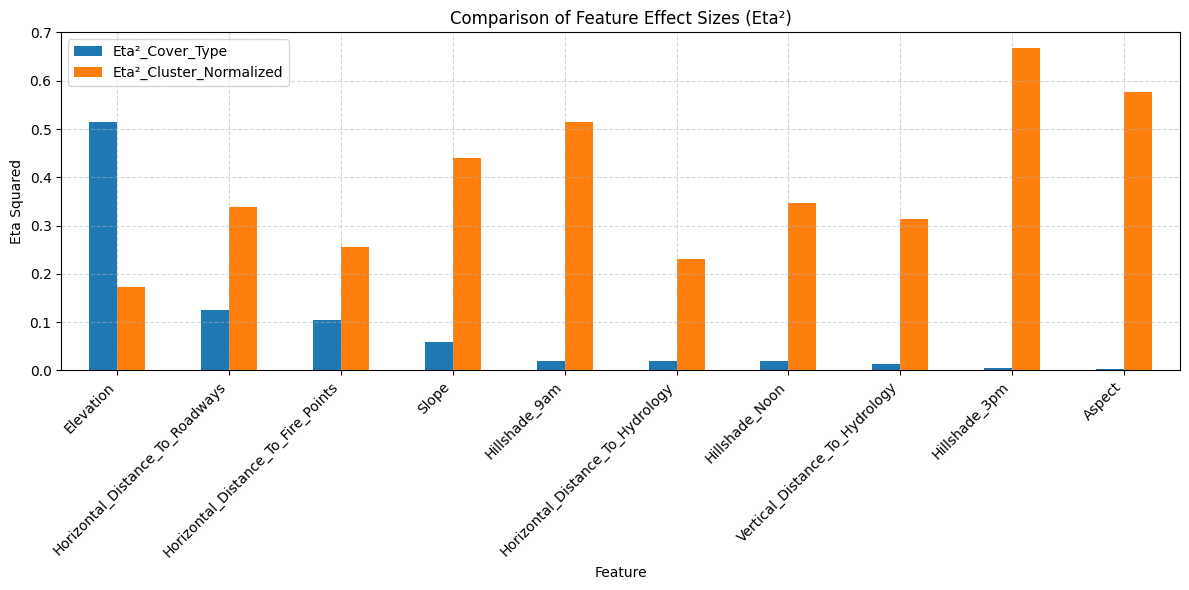

In [8]:
# Load dataset from local file
df = pd.read_csv('comparison_clusters_pca_vs_normalized.csv')

# Function to compute Kruskal-Wallis and effect size (eta²)
def compute_stats(df, label_col):
    feature_cols = df.drop(columns=['Cover_Type', 'Cluster_PCA', 'Cluster_Normalized']).columns
    results = []

    for col in feature_cols:
        groups = [df[df[label_col] == k][col].values for k in sorted(df[label_col].unique())]
        if any(len(g) == 0 or np.all(g == g[0]) for g in groups):  # Skip empty/constant groups
            continue

        stat, pval = kruskal(*groups)
        n_total = len(df)
        k = len(groups)
        eta_squared = (stat - k + 1) / (n_total - k)  # Effect size formula

        results.append({
            'Feature': col,
            'p-value': pval,
            'Eta²': eta_squared
        })

    return pd.DataFrame(results).sort_values(by='Eta²', ascending=False)

# Run analysis: supervised (Cover_Type) and unsupervised (Cluster_Normalized)
kruskal_cover = compute_stats(df, 'Cover_Type')
kruskal_cluster = compute_stats(df, 'Cluster_Normalized')

# Select top features from both views
top_features = set(kruskal_cover.head(10)['Feature']).union(set(kruskal_cluster.head(10)['Feature']))

# Merge results into one DataFrame
merged = pd.merge(
    kruskal_cover[kruskal_cover['Feature'].isin(top_features)][['Feature', 'Eta²']],
    kruskal_cluster[kruskal_cluster['Feature'].isin(top_features)][['Feature', 'Eta²']],
    on='Feature',
    suffixes=('_Cover_Type', '_Cluster_Normalized')
).set_index('Feature')

# Plot comparison of effect sizes
merged.plot(kind='bar', figsize=(12, 6), title='Comparison of Feature Effect Sizes (Eta²)', ylabel='Eta Squared')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


# Comparison between supervised and unsupervised learning

In [19]:
# Define summary metric function
def get_metrics(pred_labels, true_labels):
    ari = adjusted_rand_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)

    # Align predictions using Hungarian algorithm
    conf_mat = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-conf_mat)
    mapping_dict = {col: row for row, col in zip(row_ind, col_ind)}
    mapped_preds = pd.Series(pred_labels).map(mapping_dict)
    accuracy = np.mean(mapped_preds == true_labels)

    return {
        "ARI": ari,
        "V-Measure": v_measure,
        "Homogeneity": homogeneity,
        "Completeness": completeness,
        "NMI": nmi,
        "Accuracy (Hungarian)": accuracy
    }

# Compute metrics for both clustering methods
metrics_pca = get_metrics(cluster_pca, true_labels)
metrics_norm = get_metrics(cluster_norm, true_labels)

# Create summary table
summary_df = pd.DataFrame({
    "Metric": list(metrics_pca.keys()),
    "Cluster_PCA": [round(v, 4) for v in metrics_pca.values()],
    "Cluster_Normalized": [round(v, 4) for v in metrics_norm.values()]
})

# Display summary
print("\nComparison to Ground Truth (Cover_Type):")
print(summary_df.to_string(index=False))



📋 Comparison to Ground Truth (Cover_Type):
              Metric  Cluster_PCA  Cluster_Normalized
                 ARI       0.0240              0.0235
           V-Measure       0.0535              0.0527
         Homogeneity       0.0643              0.0633
        Completeness       0.0457              0.0451
                 NMI       0.0535              0.0527
Accuracy (Hungarian)       0.2947              0.2935


<Figure size 1000x600 with 0 Axes>

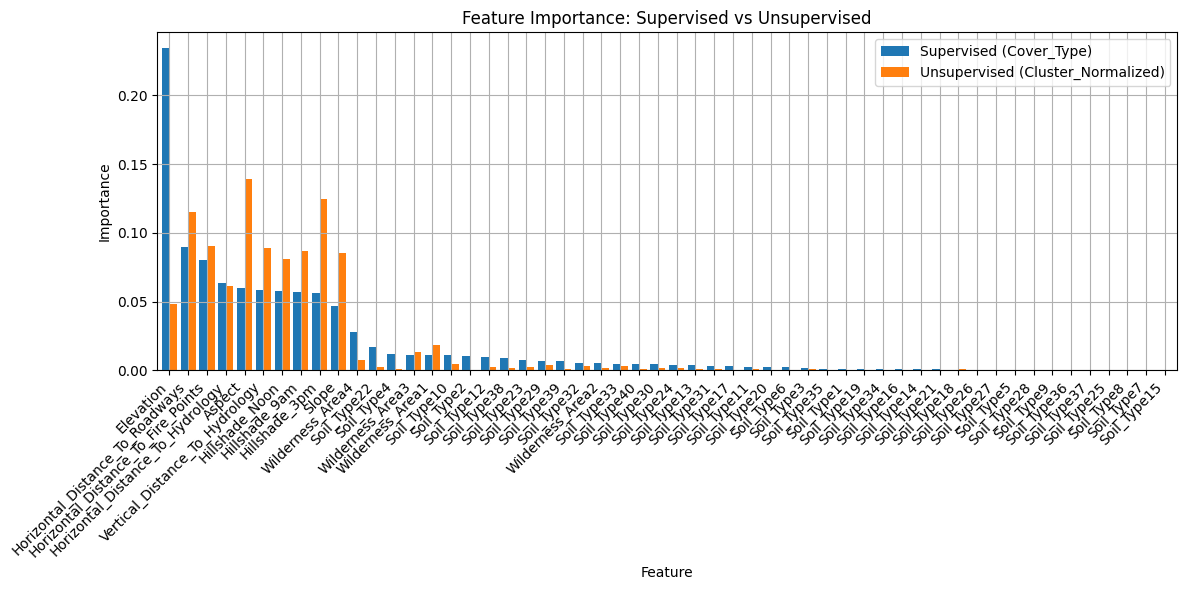

In [20]:
# Load dataset from local file
df = pd.read_csv('comparison_clusters_pca_vs_normalized.csv')

# Prepare features and targets
X = df.drop(columns=['Cover_Type', 'Cluster_Normalized', 'Cluster_PCA'])  # Only original features
y_true = df['Cover_Type']
y_cluster = df['Cluster_Normalized']

# Fit Random Forest classifier for supervised label
rf_true = RandomForestClassifier(n_estimators=100, random_state=42)
rf_true.fit(X, y_true)
importances_true = rf_true.feature_importances_

# Fit Random Forest classifier for unsupervised cluster label
rf_cluster = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cluster.fit(X, y_cluster)
importances_cluster = rf_cluster.feature_importances_

# Combine importances into DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Supervised (Cover_Type)': importances_true,
    'Unsupervised (Cluster_Normalized)': importances_cluster
}).set_index('Feature').sort_values(by='Supervised (Cover_Type)', ascending=False)

# Plot comparison
importance_df.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title("Feature Importance: Supervised vs Unsupervised")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


#Why are there differences between supervised and unsupervised learning?

<Figure size 1200x600 with 0 Axes>

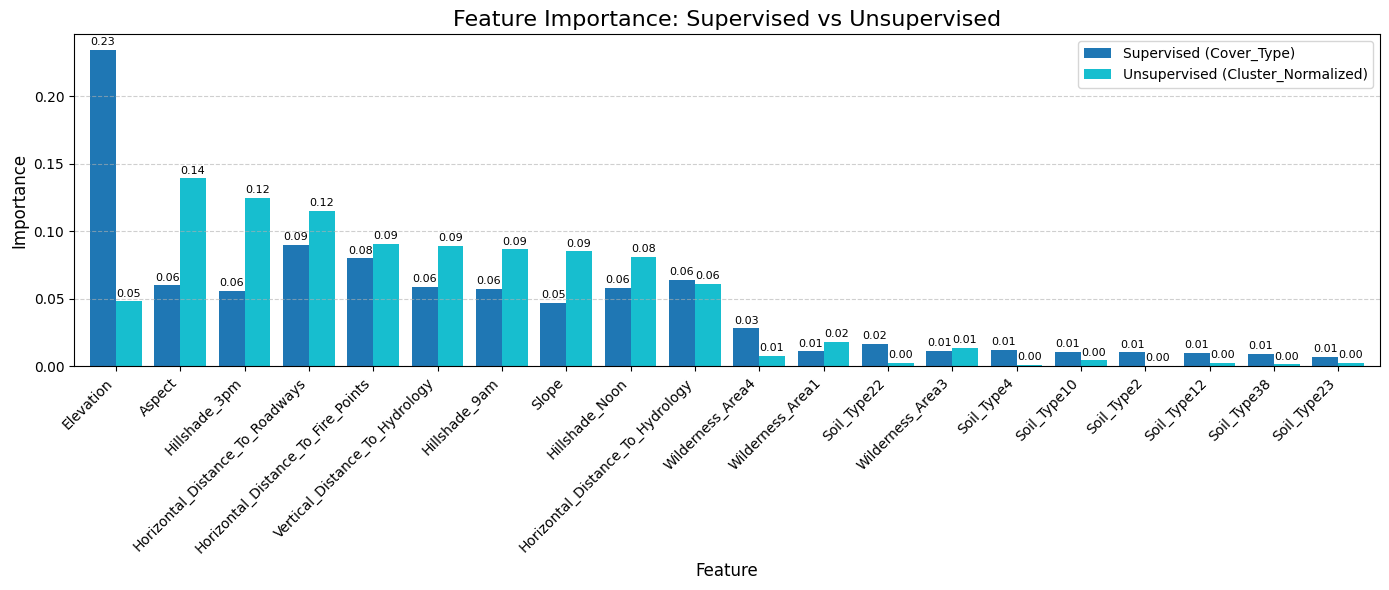

In [10]:
# Load dataset from local file
df = pd.read_csv('comparison_clusters_pca_vs_normalized.csv')

# Prepare features and labels
X = df.drop(columns=['Cover_Type', 'Cluster_Normalized', 'Cluster_PCA'])  # Only original features
y_true = df['Cover_Type']
y_cluster = df['Cluster_Normalized']

# Train Random Forest on true labels
rf_true = RandomForestClassifier(n_estimators=100, random_state=42)
rf_true.fit(X, y_true)
importances_true = rf_true.feature_importances_

# Train Random Forest on clustering labels
rf_cluster = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cluster.fit(X, y_cluster)
importances_cluster = rf_cluster.feature_importances_

# Build DataFrame of feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Supervised (Cover_Type)': importances_true,
    'Unsupervised (Cluster_Normalized)': importances_cluster
}).set_index('Feature')

# Select top N features by max importance across both models
top_n = 20
top_features = importance_df.max(axis=1).sort_values(ascending=False).head(top_n).index
importance_top = importance_df.loc[top_features]

# Plot bar chart with value labels
plt.figure(figsize=(12, 6))
ax = importance_top.plot(kind='bar', width=0.8, figsize=(14, 6), colormap='tab10')

plt.title("Feature Importance: Supervised vs Unsupervised", fontsize=16)
plt.ylabel("Importance", fontsize=12)
plt.xlabel("Feature", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels above bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=8, padding=2)

plt.tight_layout()
plt.show()


In [11]:
from scipy.stats import spearmanr

rho, pval = spearmanr(importances_true, importances_cluster)
print(f"Spearman correlation: ρ = {rho:.4f}, p-value = {pval:.4f}")

Spearman correlation: ρ = 0.9440, p-value = 0.0000


# רעיון

📊 Distribution of Cover_Type within each Cluster_Normalized (%):
Cover_Type              1      2      3     4     5      6     7
Cluster_Normalized                                              
0                   29.62  38.63  16.15  1.87  4.55   6.78  2.41
1                   45.74  45.14   2.98  0.14  1.92   1.10  2.98
2                   34.15  51.95   6.01  0.67  2.54   2.10  2.57
3                   40.70  55.93   0.00  0.00  0.44   0.00  2.94
4                   44.31  44.21   1.63  0.00  1.02   0.00  8.84
5                   23.36  39.91  23.92  0.57  0.68  11.22  0.34


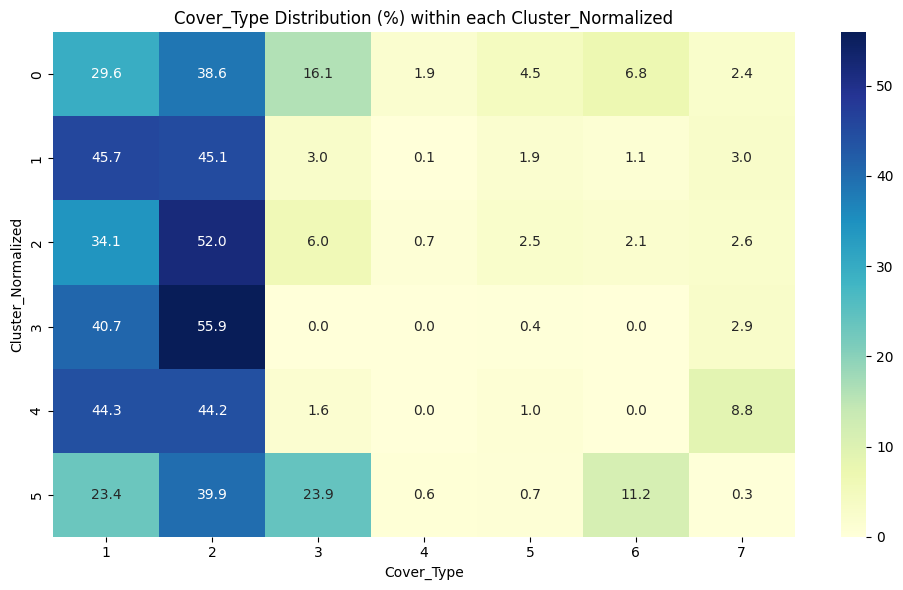

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the file (adjust path if needed)
df = pd.read_csv('comparison_clusters_pca_vs_normalized.csv')

# Cross-tabulation: how Cover_Type is distributed in each Cluster
ct_table = pd.crosstab(df['Cluster_Normalized'], df['Cover_Type'], normalize='index') * 100

# Display as table
print("📊 Distribution of Cover_Type within each Cluster_Normalized (%):")
print(ct_table.round(2))

# Heatmap visualization
plt.figure(figsize=(10, 6))
sns.heatmap(ct_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Cover_Type Distribution (%) within each Cluster_Normalized")
plt.xlabel("Cover_Type")
plt.ylabel("Cluster_Normalized")
plt.tight_layout()
plt.show()


📊 Cluster Quality Summary:
         Silhouette Mean  Silhouette Std  Size
Cluster                                       
0                  0.106           0.116  1121
1                  0.169           0.078  2182
2                  0.185           0.074  2993
3                  0.116           0.092  1838
4                  0.085           0.113   984
5                  0.117           0.123   882


<ipython-input-3-4a2ae3287a2b>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary.index, y=summary['Silhouette Mean'], palette="viridis", edgecolor="black")


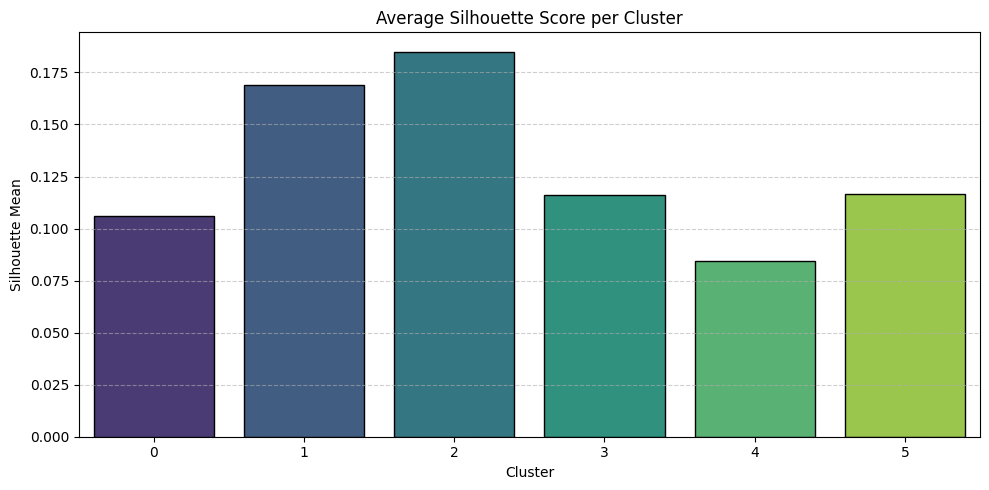

In [3]:
from sklearn.metrics import silhouette_samples
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('comparison_clusters_pca_vs_normalized.csv')

# Use only original features (drop label and cluster columns)
X = df.drop(columns=['Cover_Type', 'Cluster_Normalized', 'Cluster_PCA']).values
labels = df['Cluster_Normalized'].values

# Compute silhouette scores per sample
sil_samples = silhouette_samples(X, labels)

# Build per-cluster summary
cluster_silhouette_df = pd.DataFrame({'Cluster': labels, 'Silhouette': sil_samples})
summary = cluster_silhouette_df.groupby('Cluster').agg(['mean', 'std', 'count'])['Silhouette']
summary = summary.rename(columns={
    'mean': 'Silhouette Mean',
    'std': 'Silhouette Std',
    'count': 'Size'
})

# Display the summary
print("📊 Cluster Quality Summary:")
print(summary.round(3))

# Barplot of average silhouette per cluster
plt.figure(figsize=(10, 5))
sns.barplot(x=summary.index, y=summary['Silhouette Mean'], palette="viridis", edgecolor="black")
plt.title("Average Silhouette Score per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Silhouette Mean")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


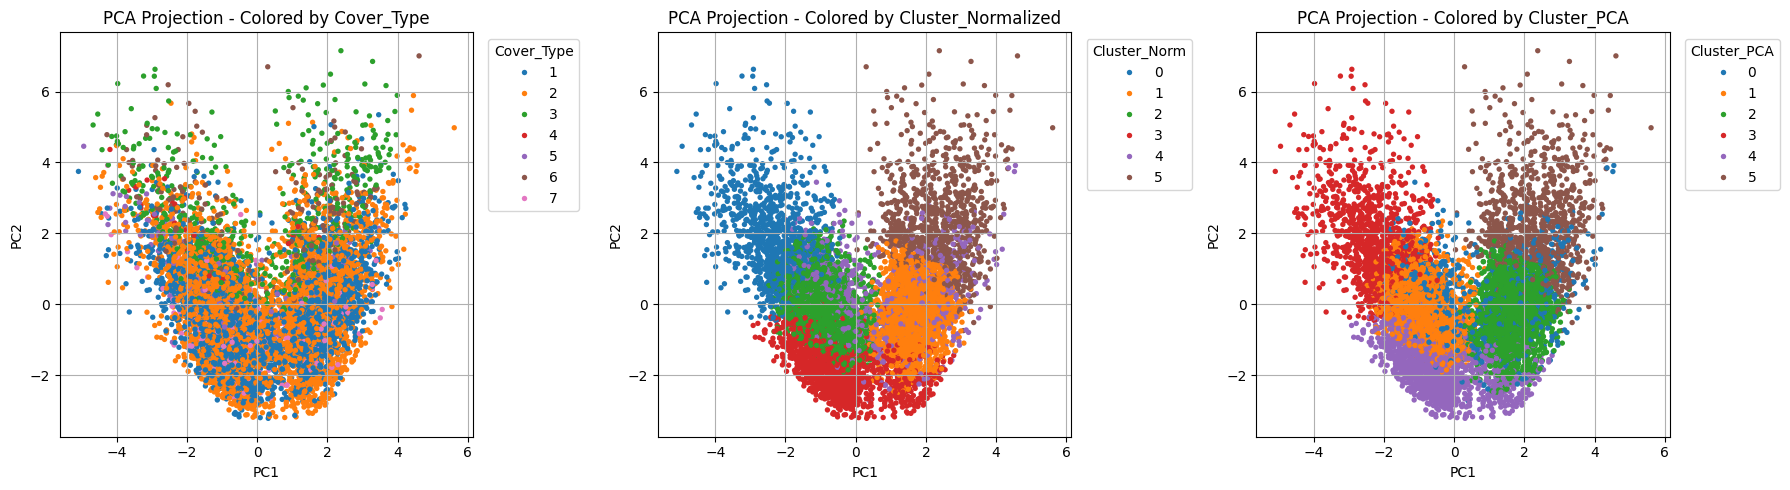

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load dataset
df = pd.read_csv('comparison_clusters_pca_vs_normalized.csv')

# Use only original features for PCA
X = df.drop(columns=['Cover_Type', 'Cluster_Normalized', 'Cluster_PCA']).values

# PCA projection
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Create a figure with 3 subplots
plt.figure(figsize=(18, 5))

# 1. Colored by Cover_Type
plt.subplot(1, 3, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cover_Type'], palette='tab10', s=15, linewidth=0)
plt.title("PCA Projection - Colored by Cover_Type")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cover_Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)

# 2. Colored by Cluster_Normalized
plt.subplot(1, 3, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster_Normalized'], palette='tab10', s=15, linewidth=0)
plt.title("PCA Projection - Colored by Cluster_Normalized")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster_Norm', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)

# 3. Colored by Cluster_PCA
plt.subplot(1, 3, 3)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster_PCA'], palette='tab10', s=15, linewidth=0)
plt.title("PCA Projection - Colored by Cluster_PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster_PCA', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


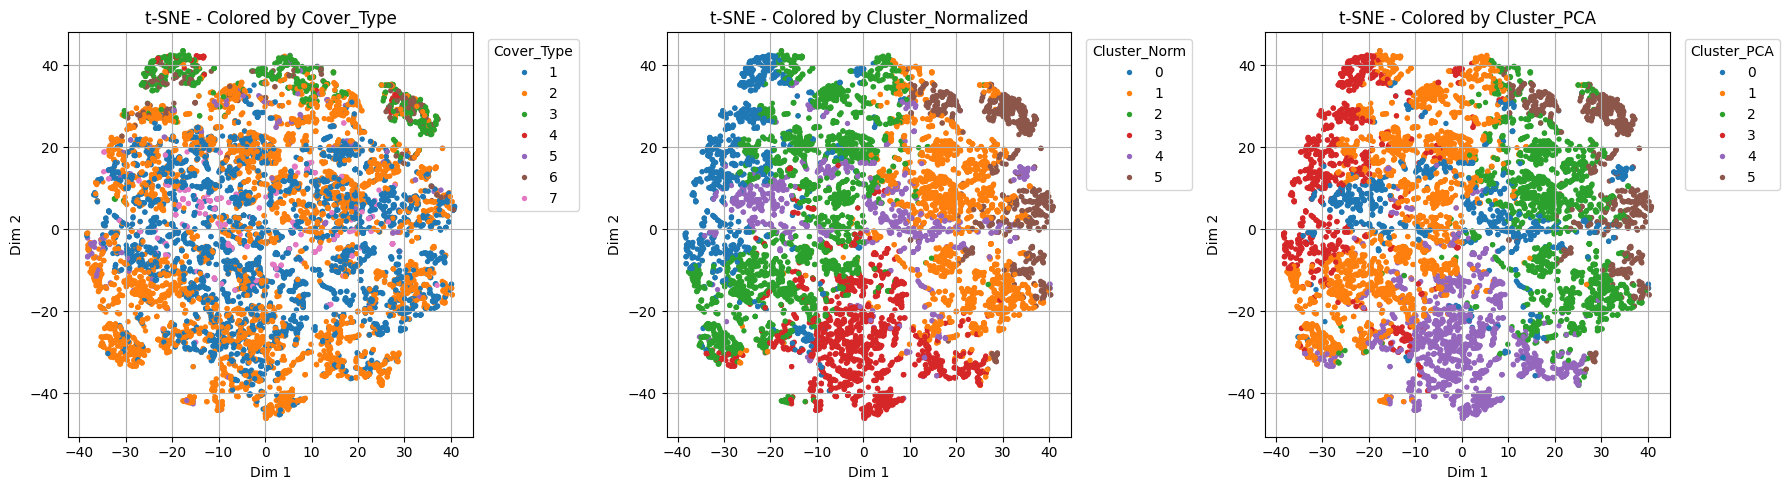

In [11]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load data
df = pd.read_csv('comparison_clusters_pca_vs_normalized.csv')
X = df.drop(columns=['Cover_Type', 'Cluster_Normalized', 'Cluster_PCA']).values

# t-SNE projection
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=500, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a figure with 3 subplots
plt.figure(figsize=(18, 5))

# 1. Cover_Type
plt.subplot(1, 3, 1)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['Cover_Type'], palette='tab10', s=15, linewidth=0)
plt.title("t-SNE - Colored by Cover_Type")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title='Cover_Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)

# 2. Cluster_Normalized
plt.subplot(1, 3, 2)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['Cluster_Normalized'], palette='tab10', s=15, linewidth=0)
plt.title("t-SNE - Colored by Cluster_Normalized")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title='Cluster_Norm', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)

# 3. Cluster_PCA
plt.subplot(1, 3, 3)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['Cluster_PCA'], palette='tab10', s=15, linewidth=0)
plt.title("t-SNE - Colored by Cluster_PCA")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title='Cluster_PCA', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


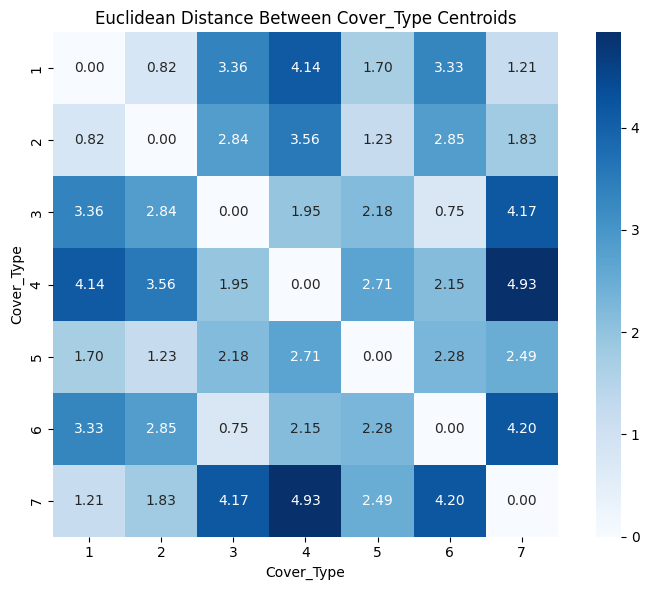

In [13]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('comparison_clusters_pca_vs_normalized.csv')

# Calculate centroids (mean of features) for each Cover_Type
feature_cols = df.drop(columns=['Cover_Type', 'Cluster_PCA', 'Cluster_Normalized']).columns
centroids = df.groupby('Cover_Type')[feature_cols].mean()

# Compute pairwise Euclidean distances between centroids
distance_matrix = pd.DataFrame(
    cdist(centroids.values, centroids.values, metric='euclidean'),
    index=centroids.index,
    columns=centroids.index
)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(distance_matrix, annot=True, fmt=".2f", cmap="Blues", square=True)
plt.title("Euclidean Distance Between Cover_Type Centroids")
plt.xlabel("Cover_Type")
plt.ylabel("Cover_Type")
plt.tight_layout()
plt.show()


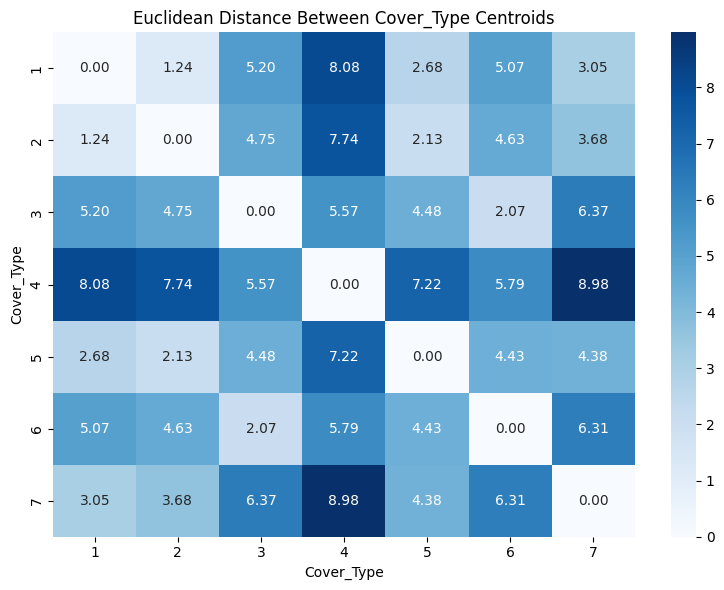

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('comparison_clusters_pca_vs_normalized.csv')

# Step 1: Normalize features again (in case it's not scaled)
features = df.drop(columns=['Cover_Type', 'Cluster_PCA', 'Cluster_Normalized'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Step 2: Calculate centroids per Cover_Type
centroids = []
for label in sorted(df['Cover_Type'].unique()):
    idx = df['Cover_Type'] == label
    centroid = X_scaled[idx].mean(axis=0)
    centroids.append(centroid)
centroids = np.array(centroids)

# Step 3: Compute pairwise distances
distances = pairwise_distances(centroids, metric='euclidean')

# Step 4: Plot heatmap of distances
plt.figure(figsize=(8, 6))
sns.heatmap(distances, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=range(1, 8), yticklabels=range(1, 8))
plt.title("Euclidean Distance Between Cover_Type Centroids")
plt.xlabel("Cover_Type")
plt.ylabel("Cover_Type")
plt.tight_layout()
plt.show()


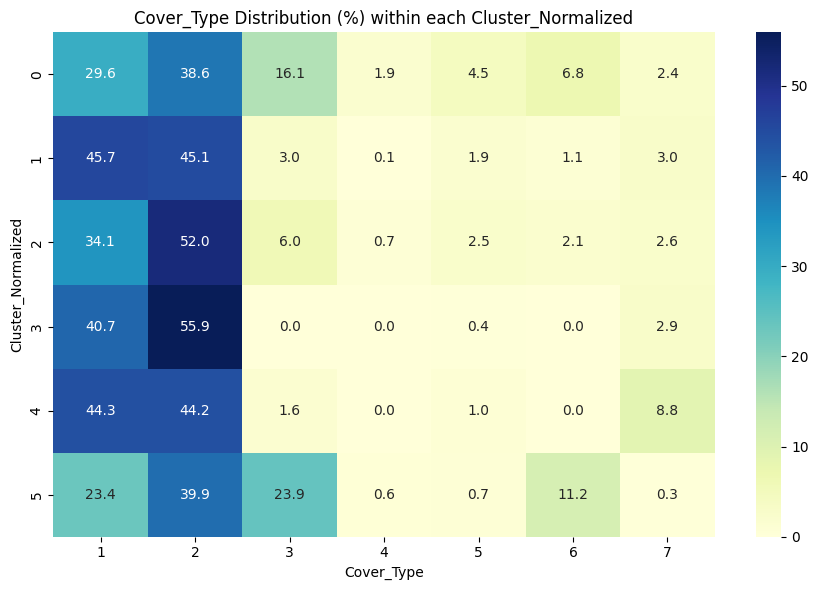

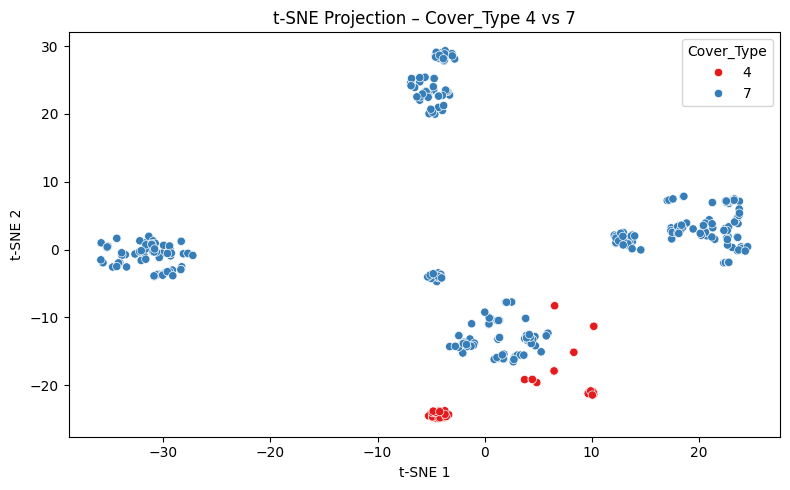

<ipython-input-17-989773890ee4>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature', palette='magma')


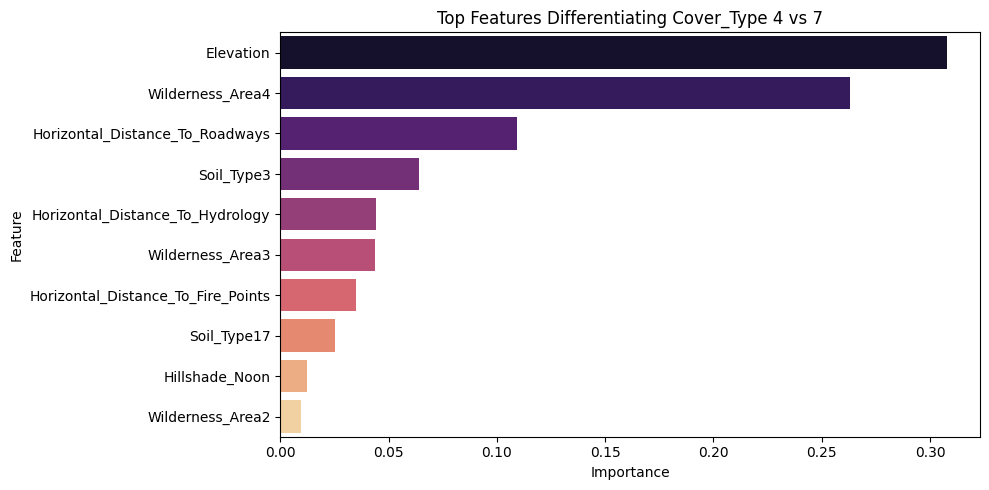

Top features from RF and whether they also differentiate Clusters (p < 0.05):
                              Feature       p-value
0                           Elevation  0.000000e+00
1                    Wilderness_Area4  0.000000e+00
2     Horizontal_Distance_To_Roadways  0.000000e+00
4    Horizontal_Distance_To_Hydrology  0.000000e+00
6  Horizontal_Distance_To_Fire_Points  0.000000e+00
5                    Wilderness_Area3  0.000000e+00
8                      Hillshade_Noon  0.000000e+00
3                          Soil_Type3  4.670316e-31
9                    Wilderness_Area2  2.310904e-28
7                         Soil_Type17  3.410437e-09


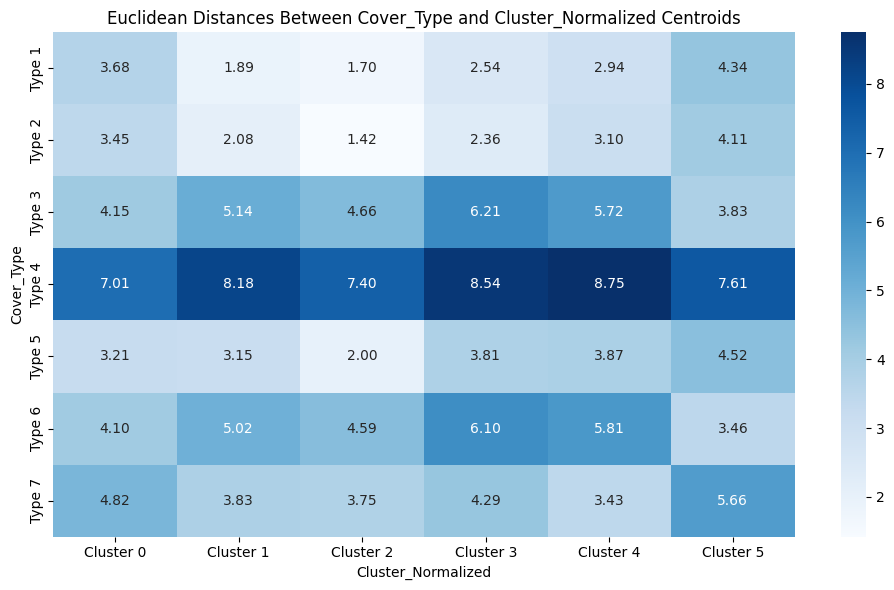

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import pairwise_distances
from scipy.stats import kruskal
import seaborn as sns
import matplotlib.pyplot as plt

# === Load and normalize data ===
df = pd.read_csv('comparison_clusters_pca_vs_normalized.csv')
feature_cols = df.drop(columns=['Cover_Type', 'Cluster_Normalized', 'Cluster_PCA']).columns
X = df[feature_cols].values
X_scaled = StandardScaler().fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=feature_cols)
df_scaled['Cover_Type'] = df['Cover_Type']
df_scaled['Cluster_Normalized'] = df['Cluster_Normalized']

# === Step 1: Heatmap of Cover_Type distribution per Cluster_Normalized ===
contingency = pd.crosstab(df['Cluster_Normalized'], df['Cover_Type'], normalize='index') * 100
plt.figure(figsize=(9, 6))
sns.heatmap(contingency, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Cover_Type Distribution (%) within each Cluster_Normalized")
plt.ylabel("Cluster_Normalized")
plt.xlabel("Cover_Type")
plt.tight_layout()
plt.show()

# === Step 2: t-SNE projection of Cover_Type 4 vs 7 only ===
df_47 = df_scaled[df_scaled['Cover_Type'].isin([4, 7])]
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne_47 = tsne.fit_transform(df_47[feature_cols])

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne_47[:, 0], y=X_tsne_47[:, 1], hue=df_47['Cover_Type'], palette='Set1')
plt.title("t-SNE Projection – Cover_Type 4 vs 7")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Cover_Type")
plt.tight_layout()
plt.show()

# === Step 3: Feature importance for distinguishing Cover_Type 4 vs 7 ===
df_47_raw = df[df['Cover_Type'].isin([4, 7])]
X_47 = df_47_raw[feature_cols]
y_47 = df_47_raw['Cover_Type']
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_47, y_47)
importances = rf.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature', palette='magma')
plt.title("Top Features Differentiating Cover_Type 4 vs 7")
plt.tight_layout()
plt.show()

# === Step 4: Kruskal test for influence of these features on Clusters ===
top_features = feat_imp_df.head(10)['Feature'].tolist()
kruskal_results = []
for col in top_features:
    groups = [df_scaled[df_scaled['Cluster_Normalized'] == c][col] for c in df_scaled['Cluster_Normalized'].unique()]
    stat, p = kruskal(*groups)
    kruskal_results.append({'Feature': col, 'p-value': p})
kruskal_df = pd.DataFrame(kruskal_results).sort_values(by='p-value')

print("Top features from RF and whether they also differentiate Clusters (p < 0.05):")
print(kruskal_df)

# === Step 5: Distance between centroids of Cover_Type vs Cluster_Normalized ===
def get_centroids(df, label_col):
    return df.groupby(label_col)[feature_cols].mean().values

centroids_cover = get_centroids(df_scaled, 'Cover_Type')
centroids_cluster = get_centroids(df_scaled, 'Cluster_Normalized')

# pairwise distances
dist_matrix = pairwise_distances(centroids_cover, centroids_cluster)

# plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(dist_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[f'Cluster {i}' for i in sorted(df["Cluster_Normalized"].unique())],
            yticklabels=[f'Type {i}' for i in sorted(df["Cover_Type"].unique())])
plt.title("Euclidean Distances Between Cover_Type and Cluster_Normalized Centroids")
plt.xlabel("Cluster_Normalized")
plt.ylabel("Cover_Type")
plt.tight_layout()
plt.show()
